# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [44]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [45]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
# print(X,y)
# print(X)
print(type(X))
print(X.shape)
print(y.shape)
# print(np.sum(X[3,:]))

with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]
    # print(csvreader)
    print(len(feature_names))
    print(type(feature_names))

<class 'numpy.ndarray'>
(180, 432)
(180,)
432
<class 'list'>


180
432
182 347
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False Fals

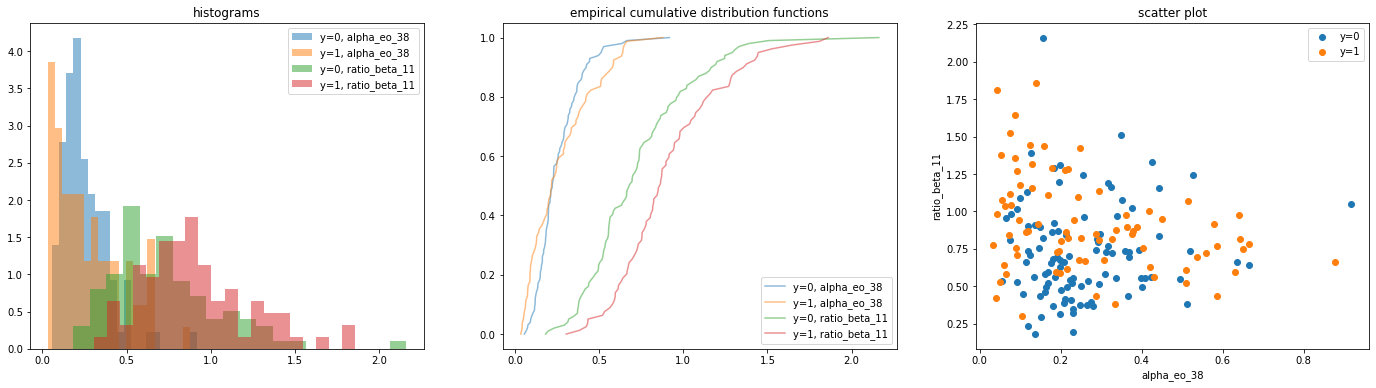

In [46]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

print(X.shape[0])
print(X.shape[1])
# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)
print(i0,i1)
# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]

print(y==0)

print(len(X00))
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [47]:
#filtering methods (at least one scoring function)

X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
from sklearn.feature_selection import VarianceThreshold
# Variance selection method, the return value is the data after feature selection
# Parameter threshold indicates the threshold of variance
print(X.shape)
print(np.median(X))
selector_model = VarianceThreshold(threshold=np.median(X))
vector_variance = selector_model.fit_transform(X)
# print("miemie")
# print(vector_variance.shape)





from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
#Chi square test
chivalue_value,pvalues_chi_value=chi2(X,y)
#How much do I take? We want to eliminate all features with a p value greater than the set value, such as 0.05 or 0.01:
k_value_sum=chivalue_value.shape[0]-(pvalues_chi_value>0.05).sum()
#Number of features minus number of deleted features
print(k_value_sum) 

vector_chi_square=SelectKBest(chi2,k=k_value_sum).fit_transform(X,y)
# vector_chi_square.shape #(42000, 300)
#Verify the model effect
scorex = cross_val_score(RFC(n_estimators=10,random_state=0),vector_chi_square,y,cv=18).mean()
print(scorex)

# wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
wrapper_model = RFE(estimator=SVR(kernel="linear"), n_features_to_select=2, step = 1).fit_transform(X, y)
wrapper_model.shape


# embedding methods  (at least one, e.g., L1 regularisation)
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2)
X_embedded = embedding.fit_transform(X)
X_embedded.shape



(180, 432)
0.253715
34
0.7388888888888889


(180, 2)

In [48]:

from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



#Different feature selection algorithms correspond to different value classification models

def classifier(temp) : 
     #split the data to  8:2
     X_train,X_test,y_train,y_test = ts(temp,y,test_size = 0.2,random_state = 42)
     box=[]
     for i in range(1,5):
          KNN = KNeighborsClassifier(n_neighbors=i)
          a = KNN.fit(X_train, y_train)
          y_pred = KNN.predict(X_test)
          scoreknn = accuracy_score(y_test, y_pred)
          print('when the n_neighbors is',i,'Knn Accuracy:',scoreknn)
          box.append(scoreknn)
          # box.index(max(box))
     print('the final knn n_neighbors is ', box.index(max(box))+1)

     #svm
     # kernel linear
     clf_linear = svm.SVC(kernel='linear')
     b = clf_linear.fit(X_train,y_train)

     #another way to calculate the value
     # tain_vector = b.predict(X_test)
     # print(tain_vector.shape)
     # print(X_train.shape)
     # svm_accuracy_score = accuracy_score(y_test, tain_vector)
     # print(svm_accuracy_score)

     score_of_linear = clf_linear.score(X_test,y_test)
     print("The score of linear kernel is : %f"%score_of_linear)

     # kernel rbf
     rbf = svm.SVC(kernel='rbf')
     rbf.fit(X_train,y_train)
     score_of_rbf = rbf.score(X_test,y_test)
     print("The score of rbf kernel is : %f"%score_of_rbf)

     # kernel poly
     ploy = svm.SVC(kernel='poly')
     ploy.fit(X_train,y_train)
     score_of_poly = ploy.score(X_test,y_test)
     print("The score of poly is kernel : %f"%score_of_poly)
     name = ['linear','rbf','poly']

     kernel_choose = [score_of_linear,score_of_rbf,score_of_poly]

     print('final svm kernel hyper-parameter value is:', name[kernel_choose.index(max(kernel_choose))])
     return a, b



groups = np.zeros(180)
for i in range(0,18):
     # print(i)
     for j in range(0,10):
          groups[i*10 + j] = i
print(groups)


def scoring_function(vector, model1,model2):
     score1 = cross_val_score(model1, vector, y,groups=groups,scoring='accuracy', cv=18)
     score2 = cross_val_score(model2, vector, y,groups=groups,scoring='accuracy', cv=18)
     print('knn final score:',score1)
     print('The mean value:',np.mean(score1))
     print('svm final score:',score2)
     print('The mean value:',np.mean(score2))


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.]


In [49]:
model1, model2 = classifier(vector_variance)
print()
model3, model4 =  classifier(vector_chi_square)
print()
model5, model6 =  classifier(wrapper_model)
print()
model7, model8 = classifier(X_embedded)
print()
print('-------------------------------------')
print("Scoring all the combos")
scoring_function(vector_variance, model1,model2)
print()
scoring_function(vector_chi_square, model3,model4)
print()
scoring_function(wrapper_model, model5,model6)
print()
scoring_function(X_embedded, model7,model8)
print()
print('-------------------------------------')
print('as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)')
#split the data to  8:2
X_train,X_test,y_train,y_test = ts(X,y,test_size = 0.2)

# kernel = 'linear'
clf_linear = svm.SVC(kernel='linear')
a = clf_linear.fit(X_train,y_train)

tain_vector = a.predict(X_test)

# print(tain_vector.shape)
# print(X_train.shape)

svm_accuracy_score = accuracy_score(y_test, tain_vector)
# print(svm_accuracy_score)

score_linear = clf_linear.score(X_test,y_test)
#linear
print("The score of SVM is : %f"%score_linear)

#KNN
X_train, X_test, y_train, y_test = ts(X, y, test_size=0.2, random_state = 42)
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

when the n_neighbors is 1 Knn Accuracy: 0.6111111111111112
when the n_neighbors is 2 Knn Accuracy: 0.6666666666666666
when the n_neighbors is 3 Knn Accuracy: 0.6944444444444444
when the n_neighbors is 4 Knn Accuracy: 0.6388888888888888
the final knn n_neighbors is  3
The score of linear kernel is : 0.722222
The score of rbf kernel is : 0.694444
The score of poly is kernel : 0.611111
final svm kernel hyper-parameter value is: linear

when the n_neighbors is 1 Knn Accuracy: 0.7222222222222222
when the n_neighbors is 2 Knn Accuracy: 0.6944444444444444
when the n_neighbors is 3 Knn Accuracy: 0.7222222222222222
when the n_neighbors is 4 Knn Accuracy: 0.7222222222222222
the final knn n_neighbors is  1
The score of linear kernel is : 0.750000
The score of rbf kernel is : 0.694444
The score of poly is kernel : 0.638889
final svm kernel hyper-parameter value is: linear

when the n_neighbors is 1 Knn Accuracy: 0.7222222222222222
when the n_neighbors is 2 Knn Accuracy: 0.7222222222222222
when the